In [1]:
import os.path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display
import itertools


In [2]:
deb_models = ['std', 'stf', 'stx', 'abj']
parameter_cols = ['p_Am', 'kap', 'v', 'p_M', 'E_G', 'h_a', 'E_Hb', 'E_Hj', 'E_Hx', 'E_Hp']
taxonomy_cols = ['family', 'order', 'class', 'phylum']
ecocode_cols = ['climate', 'ecozone', 'habitat', 'embryo', 'migrate', 'food', 'gender', 'reprod']
age_data_cols = ['ab', 'ah', 'aj', 'ax', 'ap', 'am']
time_since_birth_data_cols = ['tg', 'tb', 'tj', 'tx', 'tp']
weight_data_cols = ['Wwb', 'Wwj', 'Wwx', 'Wwp', 'Wwi']
length_data_cols = ['Lb', 'Lj', 'Lx', 'Lp', 'Li']
other_cols = ['d_V', 'Ri', 'T_typical', 't_0', 'model']

In [3]:
ERROR_VARS = ['MRE', 'SMSE']
BIJECTION_DATA_VARS = ['ab', 'ap', 'am', 'd_V', 'Wwb', 'Wwzj', 'Wwp', 'Wwi', 'R_i']

In [4]:
datasets_folder = '../data'
save_figures_folder = '../paper/figures'

In [5]:
default_palette = "muted"
sns.set_palette(palette=default_palette)

# Helper functions

In [6]:
def print_missing_values_per_column(df, columns=None, percentage=True):
    if columns is None:
        columns = df.columns
    for c in columns:
        n_missing = pd.isna(df[c]).sum()
        if n_missing:
            if percentage:
                print(f"{n_missing/len(df)*100:.1f} % missing values in column {c}")
            else:
                print(f"{n_missing} missing values in column {c}")

In [7]:
def plot_missing_values_per_column(df):
    if 'stx' not in df['model'].unique():
        df = df.drop(columns=['ax', 'tx', 'Wwx', 'Lx', 'E_Hx'])
    if 'abj' not in df['model'].unique():
        df = df.drop(columns=['aj', 'tj', 'Wwj', 'Lj', 'E_Hj'])
    df = df.drop(columns=ecocode_cols)
    missing_df = pd.Series(index=df.columns, name='n_missing')
    for col in df.columns:
        missing_df.loc[col] = pd.isna(df[col]).sum() / len(df) * 100
    missing_df = missing_df[missing_df > 0]
    missing_df
    fig, ax = plt.subplots(1,1, figsize=(12, 6))
    sns.barplot(missing_df, ax=ax)
    ax.bar_label(ax.containers[0], fmt=lambda v: f"{v:.1f}", fontsize=8)
    ax.set_ylabel('Percentage of species with a missing value')
    ax.set_ylim([0, 100])

def plot_missing_values_per_mat_level(df, ax=None):
    missing_df = pd.DataFrame(index=['birth', 'puberty', 'ultimate'], columns=['weight or length', 'age or time since birth', 'both'])
    if 'stx' in df['model'].unique():
        missing_df.loc['weaning', 'weight or length'] = ( pd.isna(df[['Wwx', 'Lx']]).all(axis=1).sum() ) 
        missing_df.loc['weaning', 'age or time since birth'] = ( pd.isna(df[['ax', 'tx']]).all(axis=1).sum() ) 
        missing_df.loc['weaning', 'both'] = ( pd.isna(df[['ax', 'tx', 'Wwx', 'Lx']]).all(axis=1).sum() ) 

    if 'abj' in df['model'].unique():
        missing_df.loc['metamorphosis', 'age or time since birth'] = ( pd.isna(df[['aj', 'tj']]).all(axis=1).sum() ) 
        missing_df.loc['metamorphosis', 'weight or length'] = ( pd.isna(df[['Wwj', 'Lj']]).all(axis=1).sum() ) 
        missing_df.loc['metamorphosis', 'both'] = ( pd.isna(df[['Wwj', 'Lj', 'aj', 'tj']]).all(axis=1).sum() ) 
        
    missing_df.loc['birth', 'weight or length'] = ( pd.isna(df[['Wwb', 'Lb']]).all(axis=1).sum() ) 
    missing_df.loc['puberty', 'weight or length'] = ( pd.isna(df[['Wwp', 'Lp']]).all(axis=1).sum() ) 
    missing_df.loc['ultimate', 'weight or length'] = ( pd.isna(df[['Wwi', 'Li']]).all(axis=1).sum() ) 

    missing_df.loc['birth', 'age or time since birth'] = ( pd.isna(df[['ab', 'tb', 'tg']]).all(axis=1).sum() ) 
    missing_df.loc['puberty', 'age or time since birth'] = ( pd.isna(df[['ap', 'tp']]).all(axis=1).sum() ) 
    missing_df.loc['ultimate', 'age or time since birth'] = ( pd.isna(df[['am']]).all(axis=1).sum() ) 

    missing_df.loc['birth', 'both'] = ( pd.isna(df[['Wwb', 'Lb', 'ab', 'tb', 'tg']]).all(axis=1).sum() ) 
    missing_df.loc['puberty', 'both'] = ( pd.isna(df[['Wwp', 'Lp', 'ap', 'tp']]).all(axis=1).sum() ) 
    missing_df.loc['ultimate', 'both'] = ( pd.isna(df[['Wwi', 'Li', 'am']]).all(axis=1).sum() ) 
    
    pct_miss_df = (missing_df / len(df) * 100).stack().reset_index() 
    pct_miss_df.columns = ['mat_level', 'data_type', 'percent_missing']
    
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(10, 6))
    sns.barplot(data=pct_miss_df, x='mat_level', y='percent_missing', hue='data_type', ax=ax)
    ax.bar_label(ax.containers[0], fmt=lambda v: f"{v:.1f}", fontsize=10)
    ax.bar_label(ax.containers[1], fmt=lambda v: f"{v:.1f}", fontsize=10)
    ax.bar_label(ax.containers[2], fmt=lambda v: f"{v:.1f}", fontsize=10)
    ax.set_xlabel('Maturity level')
    ax.set_ylabel('Percentage of species with no data')
    ax.set_ylim([0, 100])

    return pct_miss_df

# Data visualization

In [8]:
raw_dataset_name = "dataset_matlab"
raw_dataset_name += '_20250324'
raw_dataset_path = f"{datasets_folder}/raw/{raw_dataset_name}.csv"
raw_data = pd.read_csv(raw_dataset_path, index_col=0)
raw_data.dropna(how='all', inplace=True)
raw_data.index.name = 'species'
raw_data

,p_Am,kap,v,p_M,E_G,h_a,E_Hb,E_Hj,E_Hx,E_Hp,...,estim_k_J,estim_E_Hb,estim_E_Hj,estim_E_Hp,d_V,T_typical,f,t_0,model,completeness
species,,,,,,,,,,,,,,,,,,,,,
Abatus_cordatus,41.918449,0.777120,0.027220,13.844900,2393.823700,5.047000e-06,0.487600,6.941000,NaN,1403.000000,...,0,1,1,1,0.09,278.15,1.0,NaN,abj,2.5
Abbottina_rivularis,53.617532,0.971489,0.022091,21.517909,5226.313884,2.648805e-07,0.052719,0.192017,NaN,128.863865,...,0,1,1,1,0.20,291.15,1.0,153.832271,abj,2.5
Ablennes_hians,231.831215,0.996902,0.022324,21.267776,5227.569153,1.476023e-09,0.002605,0.022575,NaN,955.472281,...,0,1,1,1,0.20,301.05,1.0,NaN,abj,2.8
Abra_segmentum,8.266674,0.930000,0.020926,25.204100,2349.963100,7.505000e-07,0.000601,0.011460,NaN,10.940000,...,0,1,1,1,0.09,288.15,1.0,NaN,abj,2.1
Abralia_trigonura,109.484284,0.980810,0.009515,1009.810800,5492.358000,1.526000e-10,0.001511,2.628000,NaN,14.090000,...,0,1,1,1,0.21,291.15,1.0,NaN,abj,2.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zosterisessor_ophiocephalus,90.856433,0.977551,0.020240,17.132204,5231.466494,1.513136e-07,0.003956,NaN,NaN,1576.172765,...,0,1,0,1,0.20,290.25,1.0,NaN,std,2.5
Zosterops_lateralis,2594.395445,0.964558,0.021701,2905.710028,7322.263049,2.751121e-12,41.924067,NaN,226.319058,482.019783,...,1,1,0,1,0.28,314.75,1.0,NaN,std,2.5
Zosterops_virens,1036.789660,0.991031,0.028112,850.429303,7321.292242,3.050644e-12,17.252003,NaN,81.773428,232.181719,...,1,1,0,1,0.28,314.75,1.0,NaN,std,2.5


In [9]:
raw_data['k_J'].max()

np.float64(0.67219878446058)

In [10]:
for col in taxonomy_cols:
    print(f"{col} - {len(raw_data[col].unique())} unique")

family - 1021 unique
order - 307 unique
class - 54 unique
phylum - 20 unique


## Add-my-Pet Stats

In [11]:
raw_data['model'].value_counts()

model
abj    2518
std    2261
stx     733
stf      51
abp      16
ssj      12
hex      11
hep       9
hax       6
asj       4
sbp       4
Name: count, dtype: int64

Text(0.5, 1.0, 'Distribution of DEB models')

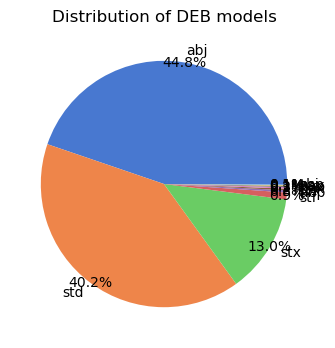

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.pie(raw_data['model'].value_counts().values, labels=raw_data['model'].value_counts().index.values, autopct='%1.1f%%', pctdistance=1)
ax.set_title('Distribution of DEB models')

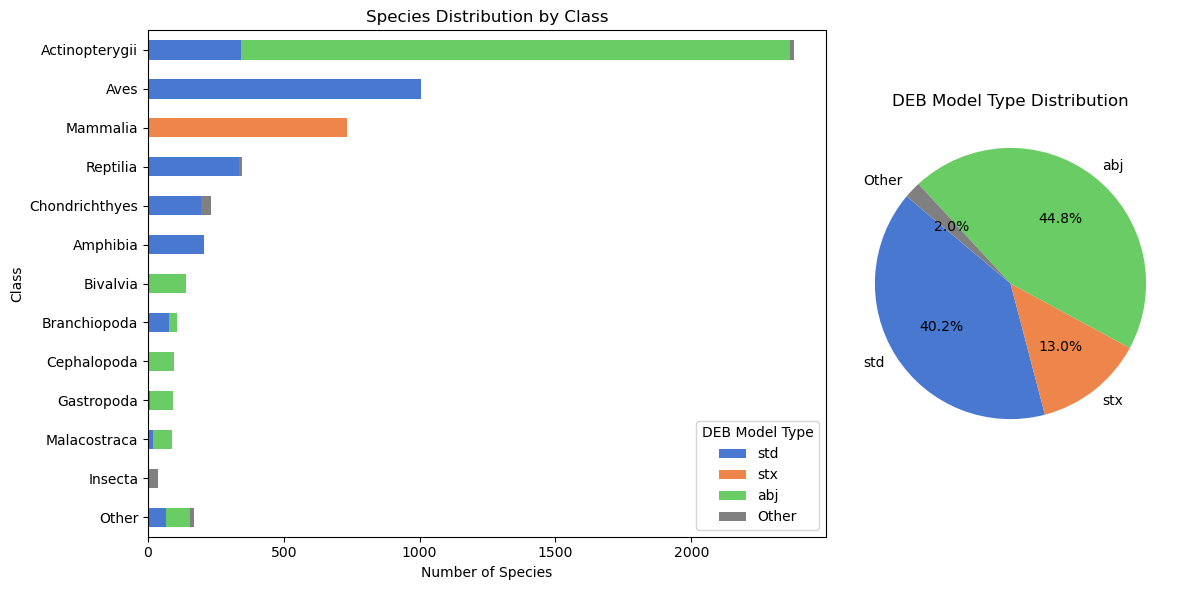

In [13]:
class_model_counts = raw_data.groupby(['class', 'model']).size().unstack(fill_value=0)
class_counts = raw_data['class'].value_counts()
model_counts = raw_data['model'].value_counts()

threshold = 20
filtered_classes = class_counts[class_counts >= threshold].index
list_of_classes_in_other = class_counts[class_counts < threshold].index
selected_models = ['std', 'stx', 'abj']
list_of_models_in_other = [m for m in model_counts.index if m not in selected_models]

grouped_class_model_counts = class_model_counts.loc[filtered_classes, selected_models]
grouped_class_model_counts.sort_index(ascending=False)
grouped_class_model_counts.loc['other_class'] = class_model_counts.loc[list_of_classes_in_other, selected_models].sum(axis=0)
grouped_class_model_counts['other_deb_model'] = 0
grouped_class_model_counts.loc[filtered_classes, 'other_deb_model'] = class_model_counts.loc[filtered_classes, list_of_models_in_other].sum(axis=1)
grouped_class_model_counts.loc['other_class', 'other_deb_model'] = class_model_counts.loc[list_of_classes_in_other, list_of_models_in_other].sum().sum()
grouped_class_model_counts = grouped_class_model_counts.iloc[::-1]
#grouped_class_model_counts

# Define colors for each DEB model type based on sorted order

deb_model_colors = dict(zip(selected_models, sns.color_palette(default_palette, n_colors=3)))
deb_model_colors['other_deb_model'] = 'gray'

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [2, 1]})

# Stacked bar chart for species per class with DEB model distribution
grouped_class_model_counts.plot(kind='barh', stacked=True, color=list(deb_model_colors.values()), ax=axes[0])
#axes[0].barh(class_deb_counts_filtered.values, labels=class_deb_counts_filtered.index, width=)
axes[0].set_title('Species Distribution by Class')
axes[0].set_xlabel('Number of Species')
axes[0].set_ylabel('Class')
legend = axes[0].get_legend()
handles, labels = axes[0].get_legend_handles_labels()
labels[-1] = 'Other'
axes[0].legend(title="DEB Model Type", handles=handles, labels=labels)
tick_labels = list(grouped_class_model_counts.index)
tick_labels[0] = 'Other'
axes[0].set_yticks(axes[0].get_yticks(), labels=tick_labels)


# Create the pie chart for DEB model types
grouped_model_counts = grouped_class_model_counts.sum(axis=0)
pie_chart_labels = list(grouped_model_counts.index)
pie_chart_labels[-1] = 'Other'
axes[1].pie(grouped_model_counts, labels=pie_chart_labels, autopct='%1.1f%%', startangle=140, colors=list(deb_model_colors.values()))
axes[1].set_title('DEB Model Type Distribution')

# Adjust layout
fig.tight_layout()
figure_filename = 'AmP_class_deb_model_dist'
fig.savefig(f'{save_figures_folder}/{figure_filename}.pdf')
fig.savefig(f'{save_figures_folder}/{figure_filename}.png', transparent=True)

<Axes: xlabel='completeness', ylabel='Count'>

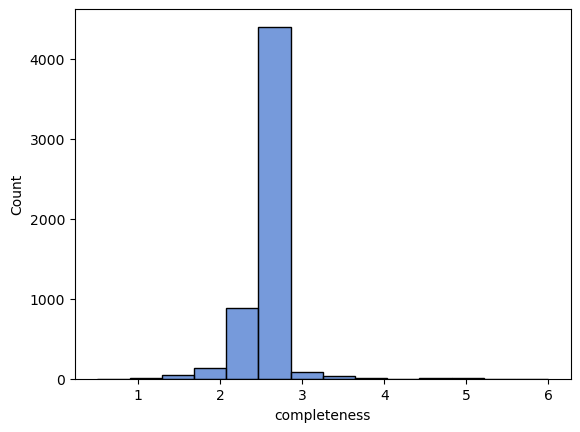

In [14]:
sns.histplot(data=raw_data, x='completeness')

## Missing values in raw data

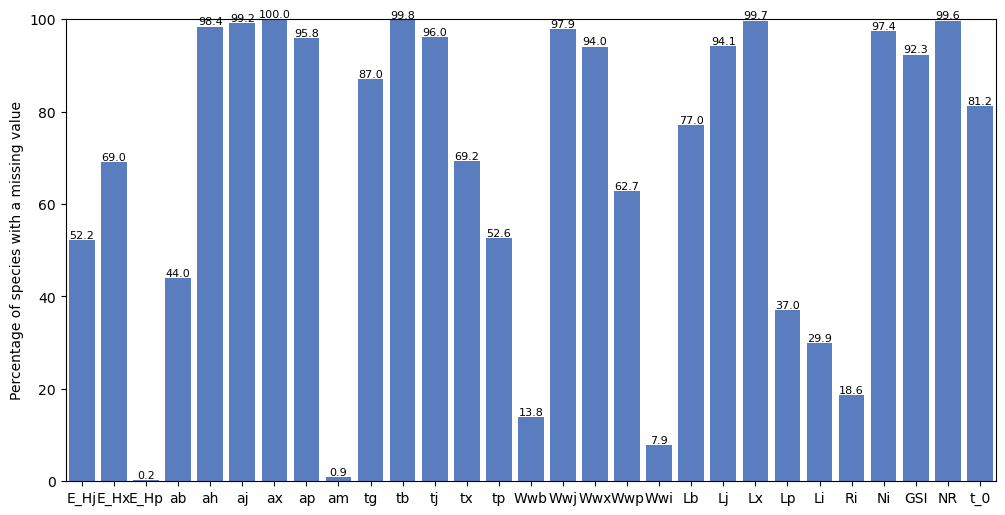

In [15]:
plot_missing_values_per_column(raw_data)

In [16]:
raw_data[raw_data['Ri'].isna() & (raw_data['completeness'] <= 5)].sort_values(by=['completeness', 'species'])

,p_Am,kap,v,p_M,E_G,h_a,E_Hb,E_Hj,E_Hx,E_Hp,...,estim_k_J,estim_E_Hb,estim_E_Hj,estim_E_Hp,d_V,T_typical,f,t_0,model,completeness
species,,,,,,,,,,,,,,,,,,,,,
Oligoneuriella_rhenana,8.082717,0.438650,0.001675,23.11870,4400.000000,1.576000e-05,5.161000e-03,NaN,NaN,3.131000e+00,...,0,1,0,1,0.17000,293.15,1.0,NaN,hep,1.0
Callianira_antarctica,12.661546,0.950000,0.031041,17.86760,264.583000,1.242000e-03,9.782000e-04,0.064830,NaN,2.381000e+00,...,0,1,1,1,0.01000,271.65,1.0,NaN,abj,1.5
Capitella_teleta,410.142394,0.863800,0.250000,410.00000,4160.000000,5.308000e-07,6.636000e-02,NaN,NaN,2.737000e+02,...,0,1,0,1,0.16000,298.15,1.0,NaN,std,1.5
Cellarinella_watersi,24.231705,0.950000,0.016583,12.84820,1833.094400,2.166000e-07,2.045000e-08,NaN,NaN,1.544000e-01,...,0,0,0,1,0.07000,273.15,1.0,NaN,std,1.5
Flustra_foliacea,28.736000,0.800000,0.002496,17.96000,1831.000000,4.697000e-07,2.045000e-08,NaN,NaN,4.716000e-01,...,0,0,0,1,0.07000,283.15,1.0,NaN,std,1.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Oncorhynchus_tshawytscha,371.189402,0.569946,0.085799,21.62576,5269.664961,2.173707e-07,1.137663e+03,66087.341119,NaN,7.516257e+06,...,1,1,1,1,0.20000,284.15,0.9,NaN,abj,3.6
Aporrectodea_caliginosa,1712.408341,0.437300,0.018505,1680.09730,6880.327700,3.258000e-07,2.063000e+01,NaN,NaN,1.167000e+03,...,0,1,0,1,0.26307,288.15,1.0,39.6592,std,4.0
Cloeon_dipterum,89.664104,0.597500,0.002990,808.98620,4469.688900,7.484000e-03,1.933000e-03,NaN,NaN,1.872000e-01,...,0,1,0,1,0.17000,293.15,1.0,13.0000,hep,4.0


In [17]:
imputation_dataset_vars = ['ab', 'tp', 'am', 'Wwb', 'Wwp', 'Wwi', 'Lb', 'Lp', 'Li', 'Ri']

# Create a checkbox widget for each string in the list
checkboxes = [widgets.Checkbox(value=True, description=col) for col in imputation_dataset_vars]

# Function to print the selected columns
def print_selected_columns(**kwargs):
    
    selected_columns = [col for col, selected in kwargs.items() if selected]
    df = raw_data[selected_columns].copy()
    n_species_all_data = len(df.dropna(how='any'))
    print(f'Species with all datasets: {n_species_all_data}')
    for col in selected_columns:
        print(f'Species with var {col}: {len(df[col].dropna())}')

# Create an interactive widget to monitor the checkbox selections
interactive_widget = widgets.interactive(print_selected_columns, **{col: checkbox for col, checkbox in zip(imputation_dataset_vars, checkboxes)})

# Display the widgets
display(widgets.HBox(checkboxes), interactive_widget.children[-1])

Output()

In [18]:
def print_dataset_stats_for_imputation(target_var):
    df = raw_data[imputation_dataset_vars].copy()
    n_species_all_data = len(df.dropna(how='any'))
    print(f'Species with all datasets: {n_species_all_data}')
    for col in imputation_dataset_vars:
        print(f'Species with var {col}: {len(df[col].dropna())}')
    
target_var_selector = widgets.Dropdown(options=imputation_dataset_vars, value=imputation_dataset_vars[0])
widgets.interactive(print_dataset_stats_for_imputation, target_var=target_var_selector)

interactive(children=(Dropdown(description='target_var', options=('ab', 'tp', 'am', 'Wwb', 'Wwp', 'Wwi', 'Lb',…

## Missing values for std species

In [19]:
raw_std_data = raw_data[raw_data['model'] == 'std'].copy()
#raw_std_data.drop(columns=['ax', 'aj', 'tx', 'tj', 'Wwx', 'Wwj', 'Lx', 'Lj', 'E_Hx', 'E_Hj'], inplace=True)
raw_std_data

,p_Am,kap,v,p_M,E_G,h_a,E_Hb,E_Hj,E_Hx,E_Hp,...,estim_k_J,estim_E_Hb,estim_E_Hj,estim_E_Hp,d_V,T_typical,f,t_0,model,completeness
species,,,,,,,,,,,,,,,,,,,,,
Abroscopus_superciliaris,852.227338,0.947562,0.031666,742.535587,7313.484440,4.198412e-12,103.106259,NaN,695.611468,1507.584831,...,1,1,0,1,0.28,314.75,1.0,NaN,std,2.5
Acanthis_flammea,3277.710396,0.878973,0.026571,3230.147843,7323.220459,2.090687e-12,173.945982,NaN,1004.636216,2067.451493,...,1,1,0,1,0.28,314.75,1.0,NaN,std,2.5
Acanthis_hornemanni,2295.936604,0.922023,0.027040,2184.935076,7323.530610,1.661944e-12,143.060638,NaN,855.181714,1675.570419,...,1,1,0,1,0.28,314.75,1.0,NaN,std,2.5
Acanthisitta_chloris,691.322259,0.694634,0.019257,468.947886,7322.088026,7.954646e-13,957.867466,NaN,5445.411544,10406.578483,...,1,1,0,1,0.28,314.75,1.0,NaN,std,2.5
Acanthiza_chrysorrhoa,1687.783701,0.849558,0.024590,1035.454894,7322.730847,1.061736e-11,785.933496,NaN,4654.670801,9867.696330,...,1,1,0,1,0.28,314.75,1.0,NaN,std,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zonotrichia_querula,4208.751230,0.971028,0.024713,3811.219492,7323.559159,3.365171e-12,71.498558,NaN,278.048289,645.380991,...,1,1,0,1,0.28,314.75,1.0,NaN,std,2.5
Zootoca_vivipara,520.970257,0.726984,0.023570,350.716818,7835.048298,1.531254e-07,221.078931,NaN,NaN,6327.201533,...,0,1,0,1,0.30,286.85,1.0,NaN,std,2.7
Zosterisessor_ophiocephalus,90.856433,0.977551,0.020240,17.132204,5231.466494,1.513136e-07,0.003956,NaN,NaN,1576.172765,...,0,1,0,1,0.20,290.25,1.0,NaN,std,2.5


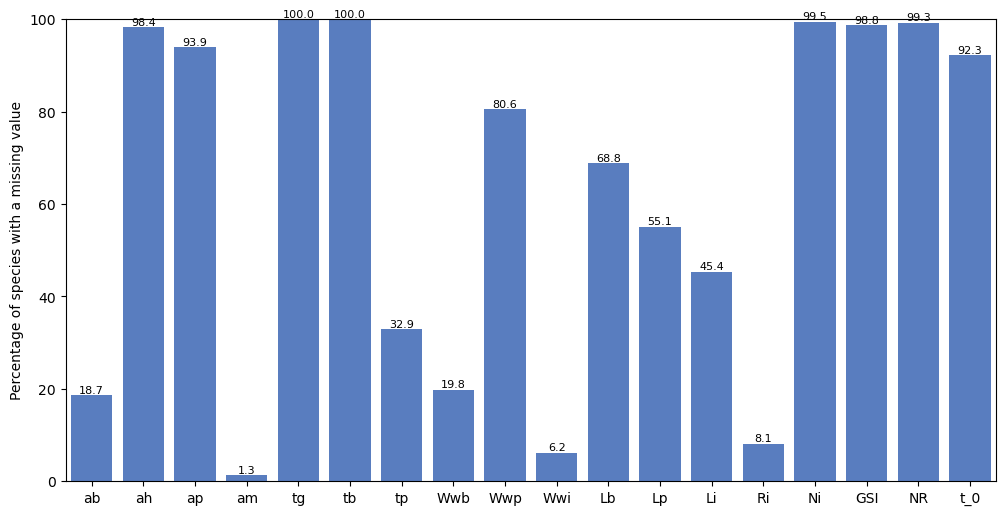

In [20]:
plot_missing_values_per_column(raw_std_data)

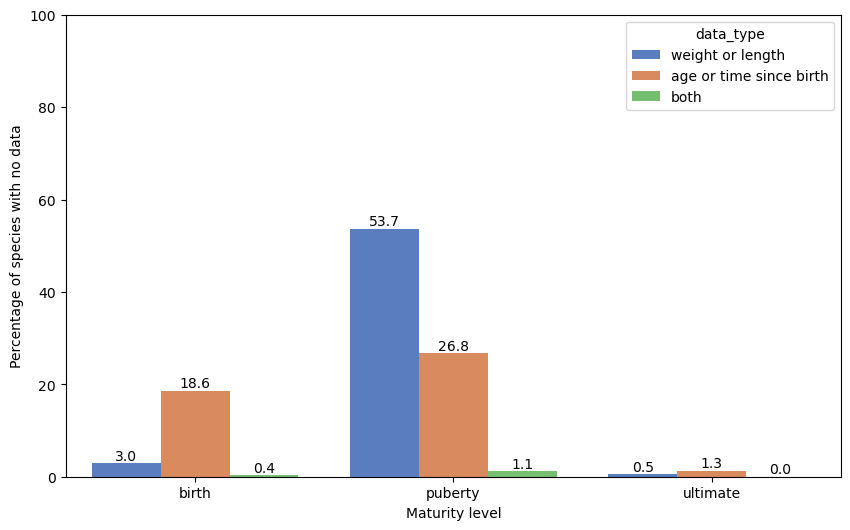

In [21]:
std_pct_miss_df = plot_missing_values_per_mat_level(raw_std_data)

## Missing values for abj species

In [22]:
raw_abj_data = raw_data[raw_data['model'] == 'abj'].copy()
raw_abj_data

,p_Am,kap,v,p_M,E_G,h_a,E_Hb,E_Hj,E_Hx,E_Hp,...,estim_k_J,estim_E_Hb,estim_E_Hj,estim_E_Hp,d_V,T_typical,f,t_0,model,completeness
species,,,,,,,,,,,,,,,,,,,,,
Abatus_cordatus,41.918449,0.777120,0.027220,13.844900,2393.823700,5.047000e-06,0.487600,6.941000,NaN,1403.000000,...,0,1,1,1,0.09,278.15,1.0,NaN,abj,2.5
Abbottina_rivularis,53.617532,0.971489,0.022091,21.517909,5226.313884,2.648805e-07,0.052719,0.192017,NaN,128.863865,...,0,1,1,1,0.20,291.15,1.0,153.832271,abj,2.5
Ablennes_hians,231.831215,0.996902,0.022324,21.267776,5227.569153,1.476023e-09,0.002605,0.022575,NaN,955.472281,...,0,1,1,1,0.20,301.05,1.0,NaN,abj,2.8
Abra_segmentum,8.266674,0.930000,0.020926,25.204100,2349.963100,7.505000e-07,0.000601,0.011460,NaN,10.940000,...,0,1,1,1,0.09,288.15,1.0,NaN,abj,2.1
Abralia_trigonura,109.484284,0.980810,0.009515,1009.810800,5492.358000,1.526000e-10,0.001511,2.628000,NaN,14.090000,...,0,1,1,1,0.21,291.15,1.0,NaN,abj,2.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zingel_asper,29.887197,0.731460,0.022384,93.592300,5234.131200,8.275000e-09,0.797400,6671.000000,NaN,6672.000000,...,0,1,1,1,0.20,289.15,1.0,NaN,abj,2.2
Zoarces_americanus,714.327542,0.695990,0.025923,50.558645,5217.091747,2.127653e-07,19.422934,19.422934,NaN,56777.096792,...,0,1,1,1,0.20,276.15,1.0,NaN,abj,2.5
Zoarces_elongatus,20.783776,0.999090,0.023702,19.842200,5216.684600,3.140000e-08,0.004859,3.046000,NaN,117.000000,...,0,1,1,1,0.20,281.15,1.0,NaN,abj,2.5


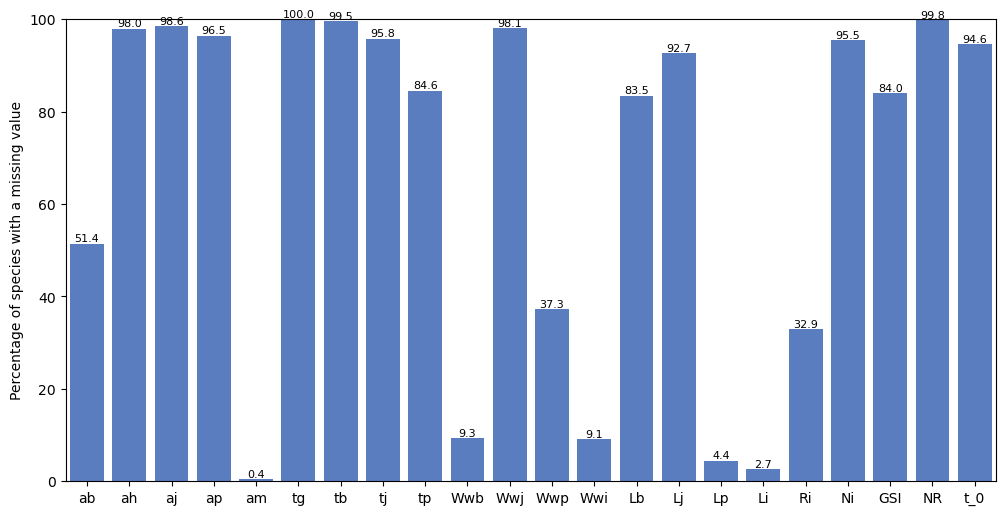

In [23]:
plot_missing_values_per_column(raw_abj_data)

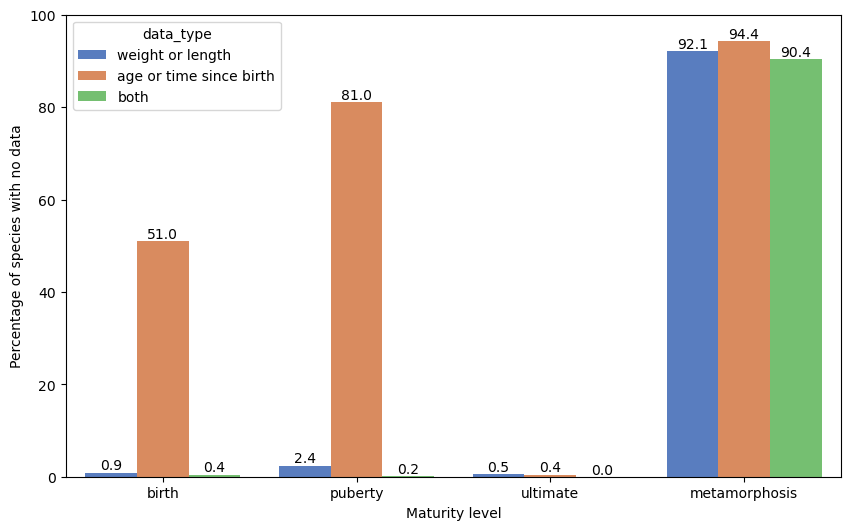

In [24]:
abj_pct_miss_df = plot_missing_values_per_mat_level(raw_abj_data)

## Missing values in stx species

In [25]:
raw_stx_data = raw_data[raw_data['model'] == 'stx'].copy()
raw_stx_data

,p_Am,kap,v,p_M,E_G,h_a,E_Hb,E_Hj,E_Hx,E_Hp,...,estim_k_J,estim_E_Hb,estim_E_Hj,estim_E_Hp,d_V,T_typical,f,t_0,model,completeness
species,,,,,,,,,,,,,,,,,,,,,
Acinonyx_jubatus,1738.396940,0.987480,0.077145,73.962800,7837.362000,1.394000e-11,1.485000e+04,NaN,3.650000e+05,3.556000e+06,...,0,1,0,1,0.3,312.15,1.0,5.226190e+01,stx,2.1
Acomys_cahirinus,2400.992637,0.935890,0.045779,1328.052600,7829.677300,7.070000e-22,1.102000e+03,NaN,7.985000e+03,5.263000e+04,...,0,1,0,1,0.3,310.65,1.0,2.090250e+01,stx,2.7
Acrobates_pygmaeus,412.338561,0.998590,0.023186,267.288000,7844.369300,2.347000e-15,6.466000e-02,NaN,8.507000e+01,3.653000e+02,...,0,1,0,1,0.3,307.85,1.0,5.891820e+01,stx,2.5
Acrocodia_indica,12083.060435,0.960380,0.076562,442.189300,7838.471900,1.798000e-16,4.241000e+05,NaN,2.198000e+07,1.550000e+08,...,0,1,0,1,0.3,309.95,1.0,3.311668e+02,stx,2.3
Addax_nasomaculatus,1947.746927,0.724170,0.181750,42.582800,7829.253600,3.892000e-20,8.431000e+06,NaN,9.192000e+07,2.755000e+08,...,0,1,0,1,0.3,311.15,1.0,2.339221e+02,stx,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zalophus_wollebaeki,2089.716672,0.865340,0.065480,49.373800,7387.147300,1.447000e-12,1.859000e+06,NaN,3.379000e+07,1.278000e+08,...,1,1,0,1,0.3,310.15,1.0,2.272490e+02,stx,2.5
Zapus_hudsonius,1165.088401,0.979010,0.029403,662.042600,7853.537200,5.076000e-10,4.259000e+01,NaN,9.317000e+02,2.908000e+03,...,0,1,0,1,0.3,307.15,1.0,4.595000e+00,stx,2.4
Zelotomys_woosnami,4586.733148,0.964740,0.070670,2508.506200,7842.414200,2.717000e-10,3.631000e+02,NaN,2.994000e+04,1.471000e+05,...,0,1,0,1,0.3,309.75,1.0,2.393420e+01,stx,2.5


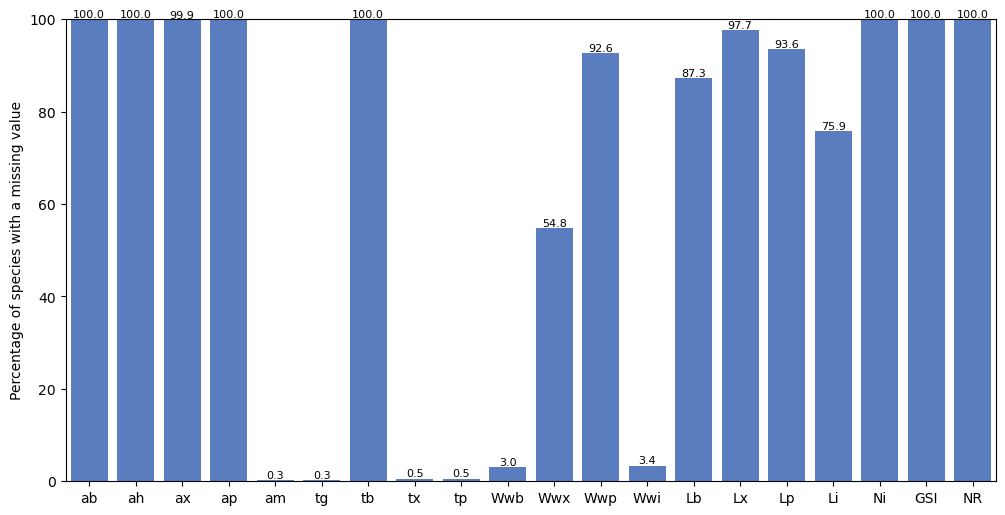

In [26]:
plot_missing_values_per_column(raw_stx_data)

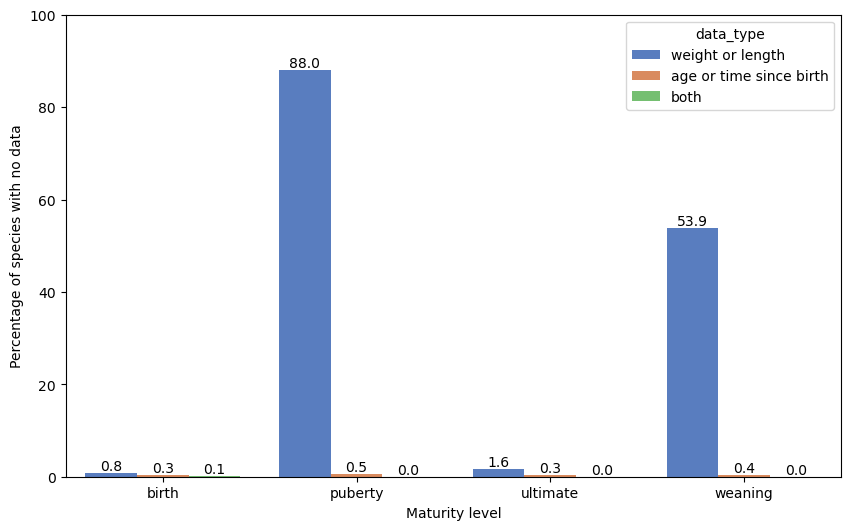

In [27]:
stx_pct_miss_df = plot_missing_values_per_mat_level(raw_stx_data)

## Summary of missing values

In [28]:
from itertools import product

list_of_mat_levels = ['birth', 'puberty', 'ultimate', 'metamorphosis']
list_of_data_types = ['weight or length', 'age or time since birth', 'both']
df_index = pd.MultiIndex.from_tuples(
    product(list_of_mat_levels, list_of_data_types),
    names=['mat_level', 'data_type']
)
mat_level_miss_df = pd.DataFrame(0, index=df_index, columns=['total', 'n_missing'], dtype=int) 
for model_type, miss_df in zip(['std', 'stx', 'abj'], [std_pct_miss_df, stx_pct_miss_df, abj_pct_miss_df]):
    n_species_with_model_type = len(raw_data.groupby('model').get_group(model_type))
    miss_df = miss_df.set_index(['mat_level', 'data_type'])
    for mat_level in list_of_mat_levels:
        for data_type in list_of_data_types:
            if (mat_level, data_type) in miss_df.index:
                mat_level_miss_df.loc[(mat_level, data_type), 'total'] += n_species_with_model_type
                mat_level_miss_df.loc[(mat_level, data_type), 'n_missing'] += int(n_species_with_model_type * miss_df.loc[(mat_level, data_type), 'percent_missing']/100)


mat_level_miss_df['percent_missing'] = mat_level_miss_df['n_missing'] / mat_level_miss_df['total'] * 100
mat_level_miss_df

total  n_missing  percent_missing
mat_level     data_type                                                 
birth         weight or length          5512         96         1.741655
              age or time since birth   5512       1705        30.932511
              both                      5512         21         0.380987
puberty       weight or length          5512       1919        34.814949
              age or time since birth   5512       2649        48.058781
              both                      5512         30         0.544267
ultimate      weight or length          5512         37         0.671263
              age or time since birth   5512         43         0.780116
              both                      5512          1         0.018142
metamorphosis weight or length          2518       2319        92.096902
              age or time since birth   2518       2376        94.360604
              both                      2518       2276        90.389198

In [29]:
#mat_level_miss_df.loc[('reproduction rate', '-'), 'n_missing'] = raw_data[['Ri', 'Ni', 'NR']].isna().all(axis=1).sum()
#mat_level_miss_df.loc[('reproduction rate', '-'), 'total'] = len(raw_data)

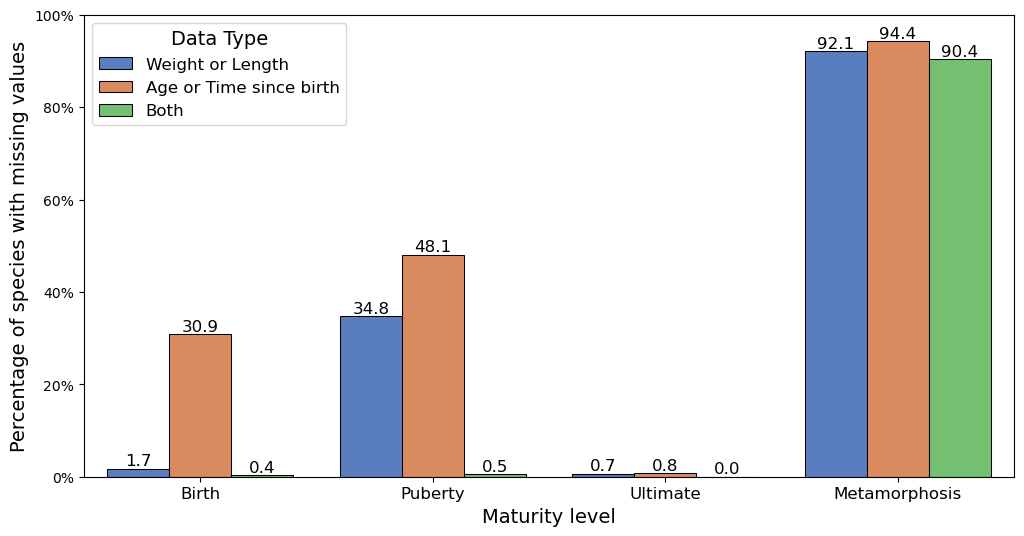

In [30]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=mat_level_miss_df, x='mat_level', y='percent_missing', hue='data_type', ax=ax, edgecolor='black', linewidth=0.75)
ax.bar_label(ax.containers[0], fmt=lambda v: f"{v:.1f}", fontsize=12)
ax.bar_label(ax.containers[1], fmt=lambda v: f"{v:.1f}", fontsize=12)
ax.bar_label(ax.containers[2], fmt=lambda v: f"{v:.1f}", fontsize=12)
ax.set_xlabel('Maturity level', fontsize=14)
ax.set_ylabel('Percentage of species with missing values', fontsize=14)
ax.yaxis.set_major_formatter(mticker.PercentFormatter(100, decimals=0))
ax.set_ylim([0, 100])
ax.set_xticks(ax.get_xticks(), labels=[s.capitalize() for s in list_of_mat_levels], fontsize=12)
handles, _ = ax.get_legend_handles_labels()
labels = ['Weight or Length', 'Age or Time since birth', 'Both']
ax.legend(title="Data Type", handles=handles, labels=labels, fontsize=12, title_fontsize=14, loc='upper left')

figure_filename = 'AmP_missing_values'
fig.savefig(f'{save_figures_folder}/{figure_filename}.pdf', dpi=300, transparent=True)
fig.savefig(f'{save_figures_folder}/{figure_filename}.png', dpi=300, transparent=True)

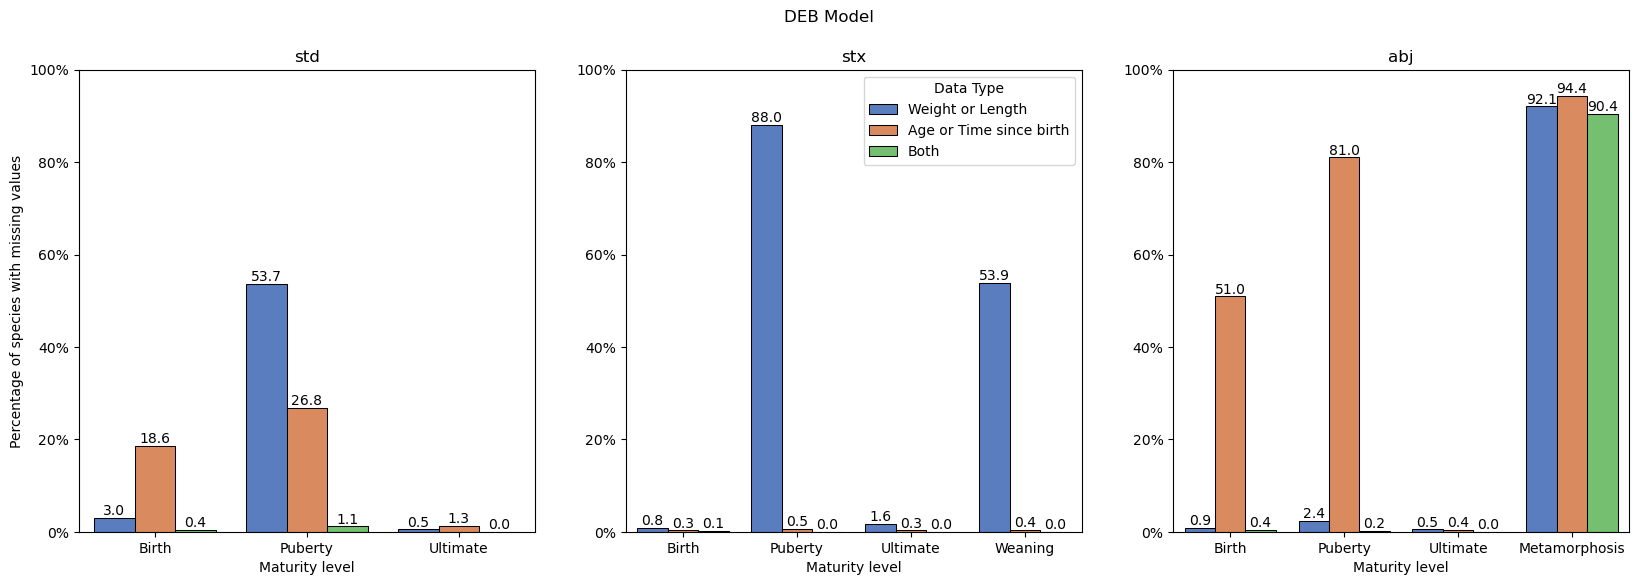

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for i, (ax, model_type, miss_df) in enumerate(zip(axes, ['std', 'stx', 'abj'], [std_pct_miss_df, stx_pct_miss_df, abj_pct_miss_df])):
    sns.barplot(data=miss_df, x='mat_level', y='percent_missing', hue='data_type', ax=ax, edgecolor='black', linewidth=0.75)
    ax.bar_label(ax.containers[0], fmt=lambda v: f"{v:.1f}", fontsize=10)
    ax.bar_label(ax.containers[1], fmt=lambda v: f"{v:.1f}", fontsize=10)
    ax.bar_label(ax.containers[2], fmt=lambda v: f"{v:.1f}", fontsize=10)
    ax.set_title(f"{model_type}")
    ax.set_xlabel('Maturity level')
    ax.set_ylim([0, 100])
    ax.set_xticks(ax.get_xticks(), labels=[s.capitalize() for s in miss_df['mat_level'].unique()])
    ax.yaxis.set_major_formatter(mticker.PercentFormatter())
    if i == 1:
        handles, _ = ax.get_legend_handles_labels()
        labels = ['Weight or Length', 'Age or Time since birth', 'Both']
        ax.legend(title="Data Type", handles=handles, labels=labels)
    else:
        ax.get_legend().remove()  # Removing legend
    if i == 0:
        ax.set_ylabel('Percentage of species with missing values')
    else:
        ax.set_ylabel('')

fig.suptitle('DEB Model') 
#fig.tight_layout()
figure_filename = 'AmP_missing_values_per_DEB_model'
fig.savefig(f'{save_figures_folder}/{figure_filename}.pdf', dpi=300, transparent=True)
fig.savefig(f'{save_figures_folder}/{figure_filename}.png', dpi=300, transparent=True)


In [37]:
raw_data[['class', 'model']].value_counts().head(30)

class               model
Actinopterygii      abj      2020
Aves                std      1005
Mammalia            stx       732
Actinopterygii      std       344
Reptilia            std       334
Amphibia            std       207
Chondrichthyes      std       194
Bivalvia            abj       133
Cephalopoda         abj        94
Gastropoda          abj        82
Branchiopoda        std        77
Malacostraca        abj        71
Chondrichthyes      stf        36
Branchiopoda        abj        30
Malacostraca        std        18
Cephalaspidomorphi  std        14
Echinoidea          abj        14
Actinopterygii      ssj        12
Clitellata          std        12
Asteroidea          abj        11
Insecta             hex        11
Reptilia            stf        11
Gastropoda          std         9
Insecta             hep         9
Ascidiacea          std         9
Hexanauplia         abp         8
Arachnida           abj         7
Insecta             abp         7
                    ha

# Errors 

## All parameter predictions

In [32]:
import sys
import os
sys.path.append(os.path.abspath('..'))
from project_code.data.load_data import load_col_types, load_data
from project_code.data.prepare_data_sklearn import get_features_targets, get_single_output_col_types
from project_code.algorithms.build_sklearn_model import build_sklearn_model
from project_code.train.train_sklearn_model import train_sklearn_model
from project_code.train.calibrate_sklearn_model import evaluate_config
from project_code.evaluate.prediction_error import evaluate_on_data
from project_code.utils.results import format_results_into_dataframe
from project_code.utils.models import save_model
from project_code.inference.parameters import get_core_parameter_predictions

ImportError: cannot import name 'load_data' from 'project_code.data.load_data' (c:\Users\diogo\OneDrive - Universidade de Lisboa\Terraprima\Code\DEB Model Calibration Algorithms\DEB_ML_Bijection\project_code\data\load_data.py)

In [ ]:
CORE_DEB_PARS = ['z', 'p_M', 'kap', 'v', 'E_G', 'h_a', 'E_Hb', 'E_Hp']

pars_df = pd.DataFrame(columns=['data_split'] + CORE_DEB_PARS, index=raw_data.index)
pars_df['data_split'] = 'test'
for col in pars_df.columns:
    if col in raw_data:
        pars_df[col] = raw_data[col].copy()
pars_df['z'] = raw_data['p_Am'] * raw_data['kap'] / raw_data['p_M'] 
results_folder = f'../results/all'
pars_df.to_csv(f'{results_folder}/parameter_predictions/AmP_predictions.csv', float_format='%.6e')
pars_df

,data_split,z,p_M,kap,v,E_G,h_a,E_Hb,E_Hp
species,,,,,,,,,
Abatus_cordatus,test,2.35290,13.8449,0.77712,0.027220,2393.8237,5.047000e-06,0.487600,1403.000
Abbottina_rivularis,test,3.06630,23.8370,0.97055,0.020221,5215.8135,3.547000e-07,0.045900,89.340
Ablennes_hians,test,11.16310,17.9765,0.99640,0.022797,5237.1062,1.614000e-09,0.003540,1083.000
Abra_segmentum,test,0.30503,25.2041,0.93000,0.020926,2349.9631,7.505000e-07,0.000601,10.940
Abralia_trigonura,test,0.10634,1009.8108,0.98081,0.009515,5492.3580,1.526000e-10,0.001511,14.090
...,...,...,...,...,...,...,...,...,...
Zosterisessor_ophiocephalus,test,5.18470,17.1271,0.97755,0.020245,5231.3551,1.513000e-07,0.003958,1577.000
Zosterops_lateralis,test,1.37930,617.3516,0.97558,0.035919,7324.4923,2.674000e-12,76.790000,1199.000
Zosterops_virens,test,1.26900,734.2559,0.99060,0.031028,7319.8077,3.005000e-12,21.060000,294.800


## Check dataset

In [ ]:
(raw_data.select_dtypes(include='number').isna())

,p_Am,kap,v,p_M,E_G,h_a,E_Hb,E_Hj,E_Hx,E_Hp,...,Li,Ri,Ni,GSI,NR,d_V,T_typical,f,t_0,completeness
species,,,,,,,,,,,,,,,,,,,,,
Abatus_cordatus,False,False,False,False,False,False,False,False,True,False,...,False,True,True,False,True,False,False,False,True,False
Abbottina_rivularis,False,False,False,False,False,False,False,False,True,False,...,False,False,True,True,True,False,False,False,False,False
Ablennes_hians,False,False,False,False,False,False,False,False,True,False,...,False,False,True,True,True,False,False,False,True,False
Abra_segmentum,False,False,False,False,False,False,False,False,True,False,...,False,False,True,True,True,False,False,False,True,False
Abralia_trigonura,False,False,False,False,False,False,False,False,True,False,...,False,True,False,True,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zosterisessor_ophiocephalus,False,False,False,False,False,False,False,True,True,False,...,False,False,True,True,True,False,False,False,True,False
Zosterops_lateralis,False,False,False,False,False,False,False,True,False,False,...,True,False,True,True,True,False,False,False,True,False
Zosterops_virens,False,False,False,False,False,False,False,True,False,False,...,True,False,True,True,True,False,False,False,True,False


In [ ]:
raw_data[(raw_data['t_0'] < 0) & (raw_data['model'] == 'stx') ]

,p_Am,kap,v,p_M,E_G,h_a,E_Hb,E_Hj,E_Hx,E_Hp,...,Ri,Ni,GSI,NR,d_V,T_typical,f,t_0,model,completeness
species,,,,,,,,,,,,,,,,,,,,,


In [ ]:
species_below_zero = {}
for col in raw_data.select_dtypes(include='number').columns:
    below_zero = raw_data[col].dropna()[raw_data[col] < 0].index.tolist()
    species_below_zero[col] = below_zero

# Print the result
for col, species_list in species_below_zero.items():
    if len(species_list):
        print(f"Parameter {col} has a negative value")
        print(*species_list, sep='\n', end='\n\n')

Parameter t_0 has a negative value
Ampullaceana_balthica
Assiminea_japonica
Boreomysis_microps
Chiromantis_rufescens
Darevskia_raddei
Epidalea_calamita
Eurycea_longicauda
Hippocampus_guttulatus
Ictalurus_punctatus
Kurtiella_bidentata
Lasaea_rubra
Lefua_echigonia
Macrognathus_pancalus
Metamysidopsis_elongata
Perna_viridis
Plestiodon_fasciatus
Sceloporus_orcutti
Scorpaenichthys_marmoratus
Sprattus_sprattus
Strangomera_bentincki



In [ ]:
mat_levels = ['E_Hb', 'E_Hx', 'E_Hj', 'E_Hp']
for col_1, col_2 in itertools.combinations(mat_levels, 2):
    species_list = raw_data[(raw_data[col_1] > raw_data[col_2]) & ~raw_data[[col_1, col_2]].isna().any(axis=1)].index.tolist()
    if species_list:
        print(f"{col_1} larger than {col_2}")
        print(*species_list, sep='\n', end='\n\n')

E_Hb larger than E_Hx
Leipoa_ocellata



In [ ]:
ages_at_mat_levels = ['ab', 'ax', 'aj', 'ap', 'am']
for col_1, col_2 in itertools.combinations(ages_at_mat_levels, 2):
    species_list = raw_data[(raw_data[col_1] > raw_data[col_2]) & ~raw_data[[col_1, col_2]].isna().any(axis=1)].index.tolist()
    if species_list:
        print(f"{col_1} larger than {col_2}")
        print(*species_list, sep='\n', end='\n\n')

## Load results

In [ ]:
results_folder = '../results/all'


## Check feasibility of parameter sets

In [ ]:
feas_df = pd.read_csv(f'{results_folder}/feasibility/AmP_feasibility.csv', index_col=0)
feas_df['feasible'] = feas_df['feasible'].astype('bool')
feas_df.index.name = 'species'

feas_df

,data_split,feasible,infeasibility_flag,error_message
species,,,,
Abatus_cordatus,test,True,0,NaN
Abbottina_rivularis,test,True,0,NaN
Ablennes_hians,test,True,0,NaN
Abra_segmentum,test,True,0,NaN
Abralia_trigonura,test,True,0,NaN
...,...,...,...,...
Zosterisessor_ophiocephalus,test,True,0,NaN
Zosterops_lateralis,test,True,0,NaN
Zosterops_virens,test,True,0,NaN


In [ ]:
feas_df[~feas_df['feasible']]['infeasibility_flag']

species
Mimachlamys_varia    timeout
Name: infeasibility_flag, dtype: object

## Check that predict file has no errors

In [ ]:
deb_loss_df = pd.read_csv(f'{results_folder}/deb_model_loss/AmP_deb_model_loss.csv', index_col=0)
deb_loss_df.index.name = 'species'
deb_loss_df['success'] = deb_loss_df['success'].astype('bool')

deb_loss_df

,data_split,deb_loss,success,error_type,error_message
species,,,,,
Abatus_cordatus,test,1.723224,True,NaN,NaN
Abbottina_rivularis,test,0.016230,True,NaN,NaN
Ablennes_hians,test,0.012216,True,NaN,NaN
Abra_segmentum,test,0.124655,True,NaN,NaN
Abralia_trigonura,test,0.638565,True,NaN,NaN
...,...,...,...,...,...
Zosterisessor_ophiocephalus,test,0.002299,True,NaN,NaN
Zosterops_lateralis,test,0.073588,True,NaN,NaN
Zosterops_virens,test,0.009154,True,NaN,NaN


In [ ]:
deb_loss_df[~deb_loss_df['success']]['error_type'].value_counts()

error_type
predict_or_loss_error    23
timeout                  16
Name: count, dtype: int64

In [ ]:
print('More than 3 minutes to run predict file')
print(*deb_loss_df[~deb_loss_df['success'] & (deb_loss_df['error_type'] == 'timeout')].index.tolist(), sep='\n', end='\n\n')

print('Parameter set did not pass a custom filter defined in the predict file')
print(*deb_loss_df[~deb_loss_df['success'] & (deb_loss_df['error_type'] == 'predict_filter')].index.tolist(), sep='\n', end='\n\n')

#print('Running the predict file caused an error')
#print(*deb_loss_df[~deb_loss_df['success'] & (deb_loss_df['error_type'] == 'predict_or_loss_error')].index.tolist(), sep='\n', end='\n\n')

More than 3 minutes to run predict file
Ameiurus_melas
Carassius_carassius
Coregonus_clupeaformis
Crossaster_papposus
Glycymeris_glycymeris
Glycymeris_pilosa
Hypsopsetta_guttulata
Microstomus_kitt
Oncorhynchus_kisutch
Penitella_penita
Pinctada_margaritifera
Placopecten_magellanicus
Ptychocheilus_grandis
Ptychocheilus_oregonensis
Seriola_dumerili
Teredo_navalis

Parameter set did not pass a custom filter defined in the predict file




In [ ]:
predict_errors_df = deb_loss_df[~deb_loss_df['success'] & (deb_loss_df['error_type'] == 'predict_or_loss_error')].sort_values(by=['error_message', 'species'])
for species in predict_errors_df.index:
    print(f"{species} - {predict_errors_df.loc[species, 'error_message']} ")


Rossia_macrosoma - Arrays have incompatible sizes for this operation. 
Amphibalanus_amphitrite - Index exceeds the number of array elements. Index must not exceed 5. 
Pollicipes_polymerus - Index exceeds the number of array elements. Index must not exceed 5. 
Rana_chensinensis - Index exceeds the number of array elements. Index must not exceed 5. 
Rana_sauteri - Index exceeds the number of array elements. Index must not exceed 5. 
Asterina_gibbosa - Index in position 2 exceeds array bounds. 
Bolinopsis_mikado - Index in position 2 exceeds array bounds. 
Crepidula_fornicata - Index in position 2 exceeds array bounds. 
Dicentrarchus_labrax - Index in position 2 exceeds array bounds. 
Ensis_directus - Index in position 2 exceeds array bounds. 
Folsomia_candida - Index in position 2 exceeds array bounds. 
Ostrea_chilensis - Index in position 2 exceeds array bounds. 
Perna_canaliculus - Index in position 2 exceeds array bounds. 
Scyliorhinus_canicula - NaN values cannot be converted to logi

# Missing values in filled data 

In [ ]:
filled_data = pd.read_csv('../data/interim/filled_data.csv', index_col=0)
filled_data

,p_Am,kap,v,p_M,E_G,h_a,E_Hb,E_Hj,E_Hx,E_Hp,...,NR,d_V,T_typical,f,t_0,model,completeness,metamorphosis,weaning,foetus
species,,,,,,,,,,,,,,,,,,,,,
Abatus_cordatus,41.918449,0.77712,0.027220,13.8449,2393.8237,5.047000e-06,0.487600,6.941000,NaN,1403.000,...,NaN,0.09,278.15,1.0,NaN,abj,2.5,True,False,False
Abbottina_rivularis,75.309251,0.97055,0.020221,23.8370,5215.8135,3.547000e-07,0.045900,0.069550,NaN,89.340,...,NaN,0.20,291.15,1.0,149.8737,abj,2.5,True,False,False
Ablennes_hians,201.398502,0.99640,0.022797,17.9765,5237.1062,1.614000e-09,0.003540,0.029360,NaN,1083.000,...,NaN,0.20,301.05,1.0,NaN,abj,2.8,True,False,False
Abra_segmentum,8.266674,0.93000,0.020926,25.2041,2349.9631,7.505000e-07,0.000601,0.011460,NaN,10.940,...,NaN,0.09,288.15,1.0,NaN,abj,2.1,True,False,False
Abralia_trigonura,109.484284,0.98081,0.009515,1009.8108,5492.3580,1.526000e-10,0.001511,2.628000,NaN,14.090,...,NaN,0.21,291.15,1.0,NaN,abj,2.3,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zosterisessor_ophiocephalus,90.838193,0.97755,0.020245,17.1271,5231.3551,1.513000e-07,0.003958,NaN,NaN,1577.000,...,NaN,0.20,290.25,1.0,NaN,std,2.5,False,False,False
Zosterops_lateralis,872.827510,0.97558,0.035919,617.3516,7324.4923,2.674000e-12,76.790000,NaN,456.8,1199.000,...,NaN,0.28,314.75,1.0,NaN,std,2.5,False,False,False
Zosterops_virens,940.612495,0.99060,0.031028,734.2559,7319.8077,3.005000e-12,21.060000,NaN,101.4,294.800,...,NaN,0.28,314.75,1.0,NaN,std,2.5,False,False,False


In [ ]:
print_missing_values_per_column(filled_data)

54.7 % missing values in column E_Hj
66.1 % missing values in column E_Hx
0.0 % missing values in column climate
0.0 % missing values in column ecozone
0.0 % missing values in column habitat
0.0 % missing values in column embryo
64.6 % missing values in column migrate
0.0 % missing values in column food
0.0 % missing values in column gender
0.0 % missing values in column reprod
29.5 % missing values in column ab
98.4 % missing values in column ah
96.5 % missing values in column aj
80.5 % missing values in column ax
64.0 % missing values in column ap
0.9 % missing values in column am
85.8 % missing values in column tg
99.8 % missing values in column tb
96.3 % missing values in column tj
66.4 % missing values in column tx
48.8 % missing values in column tp
3.7 % missing values in column Wwb
94.2 % missing values in column Wwj
93.4 % missing values in column Wwx
22.8 % missing values in column Wwp
6.3 % missing values in column Wwi
75.8 % missing values in column Lb
94.2 % missing values 

C:\Users\diogo\AppData\Local\Temp\ipykernel_3488\2358594085.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filled_std_data = filled_data[raw_data['model'] == 'std'].copy()
C:\Users\diogo\AppData\Local\Temp\ipykernel_3488\2358594085.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filled_stx_data = filled_data[raw_data['model'] == 'stx'].copy()
C:\Users\diogo\AppData\Local\Temp\ipykernel_3488\2358594085.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filled_abj_data = filled_data[raw_data['model'] == 'abj'].copy()


Text(0.5, 1.0, 'abj')

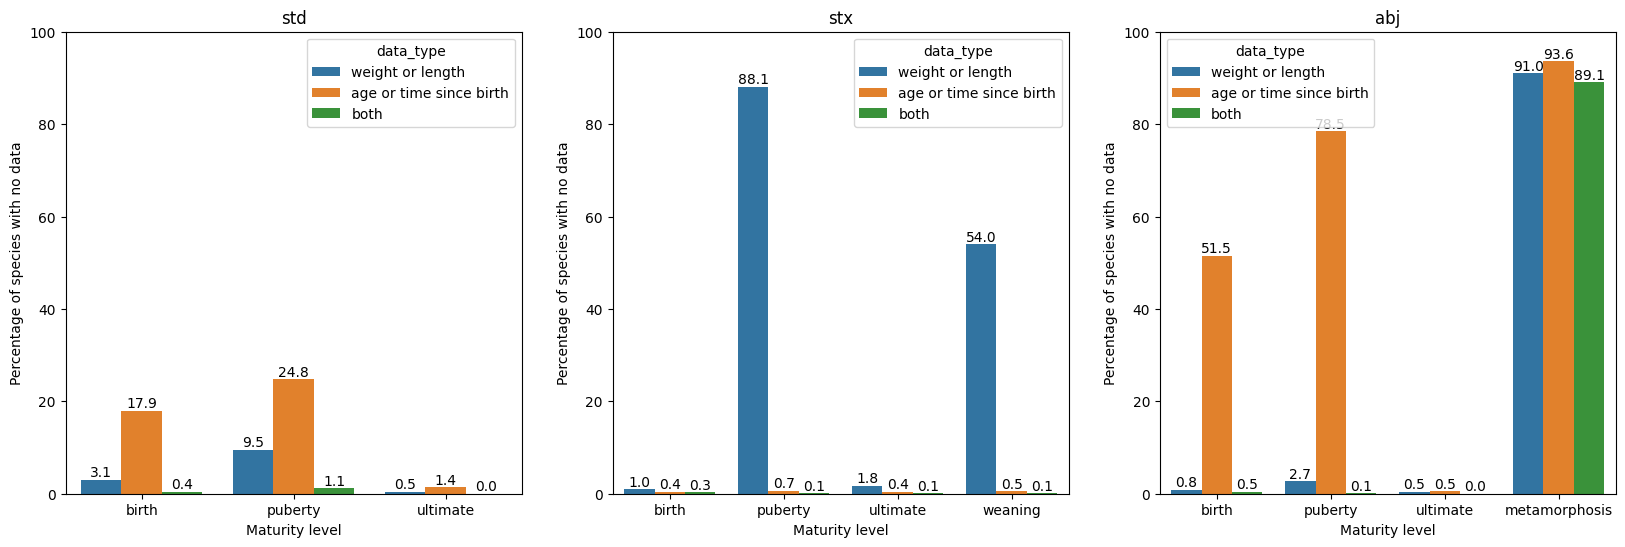

In [ ]:
filled_std_data = filled_data[raw_data['model'] == 'std'].copy()
filled_stx_data = filled_data[raw_data['model'] == 'stx'].copy()
filled_abj_data = filled_data[raw_data['model'] == 'abj'].copy()
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
plot_missing_values_per_mat_level(filled_std_data, ax=axes[0])
axes[0].set_title('std')
plot_missing_values_per_mat_level(filled_stx_data, ax=axes[1])
axes[1].set_title('stx')
plot_missing_values_per_mat_level(filled_abj_data, ax=axes[2])
axes[2].set_title('abj')

## Number of samples depending on datasets used

In [ ]:
bijection_datasets = ['ab', 'ax', 'aj', 'ap', 'am', 'd_V', 'Wwb', 'Wwx', 'Wwj', 'Wwp', 'Wwi', 'Ri']
print_missing_values_per_column(filled_data, columns=bijection_datasets)

29.5 % missing values in column ab
80.5 % missing values in column ax
96.5 % missing values in column aj
64.0 % missing values in column ap
0.9 % missing values in column am
3.7 % missing values in column Wwb
93.4 % missing values in column Wwx
94.2 % missing values in column Wwj
42.3 % missing values in column Wwp
6.3 % missing values in column Wwi
16.1 % missing values in column Ri


In [ ]:
abj_columns = ['E_Hj', 'Wwj', 'aj']
stx_columns = ['E_Hx', 'Wwx', 'ax']
def drop_species_with_missing_values(df):

    # abj models
    subset = [col for col in df.columns if col not in stx_columns]
    print(len(subset), subset)
    abj_df = df[df['metamorphosis']].dropna(subset=subset)

    # stx models
    subset = [col for col in df.columns if col not in abj_columns]
    print(len(subset), subset)
    stx_df = df[df['weaning']].dropna(subset=subset)
    
    # std models
    subset = [col for col in df.columns if col not in abj_columns and col not in stx_columns]
    print(len(subset), subset)
    std_df = df[~df['weaning'] & ~df['metamorphosis']].dropna(subset=subset)
    
    filtered_df = pd.concat([abj_df, std_df, stx_df], axis=0)
    
    print('std', len(std_df), len(std_df)/len(filtered_df))
    print('stx', len(stx_df), len(stx_df)/len(filtered_df))
    print('abj', len(abj_df), len(abj_df)/len(filtered_df))
    
    return filtered_df

In [ ]:
# Create a checkbox widget for each string in the list
checkboxes = [widgets.Checkbox(value=True, description=col) for col in bijection_datasets]

# Function to print the selected columns
def print_selected_columns(**kwargs):
    
    selected_columns = [col for col, selected in kwargs.items() if selected] + ['metamorphosis', 'weaning', 'foetus']
    sel_df = filled_data[selected_columns]
    sel_df = drop_species_with_missing_values(sel_df)
    print(len(sel_df))

# Create an interactive widget to monitor the checkbox selections
interactive_widget = widgets.interactive(print_selected_columns, **{col: checkbox for col, checkbox in zip(bijection_datasets, checkboxes)})

# Display the widgets
display(widgets.HBox(checkboxes), interactive_widget.children[-1])


Output()

## Number of samples depending on the datasets chosen for each maturity level

In [ ]:
n_samples_df = pd.DataFrame(columns=['b', 'bjx', 'p', 'n_samples'], index=range(3*3*3))
base_cols = ['am', 'd_V', 'Wwi', 'Ri']
i = 0

def get_data_types(data_types):
    if len(data_types) == 2:
        return 'both'
    elif data_types[0][0] == 'a':
        return 'age'
    else:
        return 'weight'
    
"""for b_data in [['ab'], ['Wwb'], ['ab', 'Wwb']]:
    for bjx_data in [['abjx'], ['Wwbjx'], ['abjx', 'Wwbjx']]:
        for p_data in [['ap'], ['Wwp'], ['ap', 'Wwp']]:
            n_samples_df.loc[i, 'b'] = get_data_types(b_data)
            n_samples_df.loc[i, 'bjx'] = get_data_types(bjx_data)
            n_samples_df.loc[i, 'p'] = get_data_types(p_data)
            cols = base_cols + b_data + bjx_data + p_data
            n_samples_df.loc[i, 'n_samples'] = len(filled_data[cols].dropna(how='any', axis=0))
            i += 1"""
for b_data in [['ab'], ['Wwb'], ['ab', 'Wwb']]:
    for p_data in [['ap'], ['Wwp'], ['ap', 'Wwp']]:
        n_samples_df.loc[i, 'b'] = get_data_types(b_data)
        n_samples_df.loc[i, 'bjx'] = get_data_types(bjx_data)
        n_samples_df.loc[i, 'p'] = get_data_types(p_data)
        cols = base_cols + b_data + p_data
        n_samples_df.loc[i, 'n_samples'] = len(filled_data[cols].dropna(how='any', axis=0))
        i += 1

n_samples_df.sort_values(by='n_samples', ascending=False)           

NameError: name 'bjx_data' is not defined